In [ ]:
# we need the following libraries, so let's install them
%pip install matplotlib
%pip install scikit-learn
%pip install tensorflow
%pip install imblearn

In [1]:
# importing libraries
from time import time
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from glob import glob
import skimage
from  imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import sys
import warnings
from sklearn.utils import shuffle
import random
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import logging
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore", category=DeprecationWarning)
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# loadnig the data and removing the useless column 'Unnamed: 0'
whole_data = pd.read_csv('/content/gdrive/MyDrive/radiomics/Chexpert_synced_data_nan_free.csv')
# whole_data = pd.read_csv('Chexpert_synced_data_nan_free.csv')
whole_data.head(5)

,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0,-669.603949,685.781964,1.059520e+10,6.017600,866.092155,1.713989,934.117676,428.763596,10.279660,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,-801.474548,564.486328,1.274714e+10,6.146630,954.811813,1.756523,1020.768616,468.058052,-132.958831,...,0.0,1.0,1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,1.0
2,2,-844.417249,307.704349,9.364581e+09,5.848908,690.788330,1.913630,589.552979,354.572276,-308.642302,...,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
3,4,-742.036096,673.796082,1.132259e+10,6.076017,1038.149048,1.627926,933.427429,467.972161,-17.909900,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,5,-802.322357,560.980408,1.410547e+10,6.061123,783.288322,2.001557,869.513733,412.838385,-210.721353,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0


In [5]:
# excludiung Ages with Nans
temporary_labels = np.zeros((whole_data.shape[0],))
for i, val in enumerate(whole_data['Race'].values):
    if 'White' in val:
        temporary_labels[i] = 0
    elif 'Black' in val or 'African American' in val:
        temporary_labels[i] = 1
    elif 'Asian' in val:
        temporary_labels[i] = 2
    else:
        temporary_labels[i] = np.nan


In [6]:
# the number of each label:
# white, african american, asian
(temporary_labels==0).sum(), (temporary_labels==1).sum(), (temporary_labels==2).sum()
all_n = (temporary_labels==0).sum() + (temporary_labels==1).sum() + (temporary_labels==2).sum()

In [8]:
whole_data['new_race'] = temporary_labels.tolist()

In [10]:
whole_data = whole_data[~pd.isnull(whole_data['new_race'])]

In [11]:
whole_data.shape

(135406, 490)

In [12]:
random_seed = 21202
del whole_data['Unnamed: 0']
whole_data.head()
whole_data = whole_data.sample(frac=1.0, random_state=random_seed)

In [13]:
# finding total number of samples:
n_samples = whole_data.shape[0]
print("number of samples are: {}".format(n_samples))

number of samples are: 135406


In [14]:
# names of all targets:
targets_names = list(whole_data.iloc[:,464:])
print(targets_names)

['index', 'Path', 'Patient_id', 'Study_Number', 'Sex', 'Age', 'Race', 'Ethnicity', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'new_race']


In [15]:
# finding the number of unique subjects:
unique_subjects = pd.unique(whole_data['Patient_id'])
print('The number of unique subjects are: {0}'.format(len(unique_subjects)))

The number of unique subjects are: 46107


In [16]:
# preallocating the frequency of session of the subjects:
# this is written to make sure that we dont use a subject in both training and testing split.
test_split = 0.06       # precent out of total samples
valid_split = 0.1       # precent out of total samples (this is the sumation of both training and validation splits)

n_test = n_samples * test_split
n_whole_train = n_samples - n_test

frequencies = np.ones((unique_subjects.shape[0], 4)) * np.nan
for i, sbj in tqdm(enumerate(unique_subjects)):
  frequencies[i, 0] = sbj
  frequencies[i, 1] = (whole_data['Patient_id'] == sbj).sum()
cumolative_sums_of_samples = np.cumsum(frequencies[:,1])
frequencies[:, 2] = cumolative_sums_of_samples
frequencies[:, 3] = cumolative_sums_of_samples/cumolative_sums_of_samples[~0]

46107it [00:16, 2802.37it/s]


In [17]:
# visualizing the frequency  of subjects and images taken from each
vis_frequencies = pd.DataFrame(frequencies,columns=['subject_ID','n_of_sessions/images','cumolative_sessions','preccent_of_number_of_images'])
vis_frequencies.head(15)

,subject_ID,n_of_sessions/images,cumolative_sessions,preccent_of_number_of_images
0,38202.0,3.0,3.0,0.000022
1,10143.0,3.0,6.0,0.000044
2,28750.0,1.0,7.0,0.000052
3,56970.0,2.0,9.0,0.000066
4,37884.0,23.0,32.0,0.000236
5,33968.0,3.0,35.0,0.000258
6,7770.0,5.0,40.0,0.000295
7,5640.0,4.0,44.0,0.000325
8,11368.0,2.0,46.0,0.000340
9,46543.0,2.0,48.0,0.000354


In [18]:
# separating the testing split without having any mutual_subjects:
testing_subjects_masking = vis_frequencies['preccent_of_number_of_images'] < test_split
testing_subjects = vis_frequencies[testing_subjects_masking]['subject_ID'].values.tolist()
whole_train_subjects = vis_frequencies[~testing_subjects_masking]['subject_ID'].values.tolist()

In [19]:
# excluding irrelevant features
excluding2ds =  np.concatenate( (np.arange(32,41,dtype=int),
                                 np.arange(32,41,dtype=int)+ 116,
                                 np.arange(32,41,dtype=int)+116*2,
                                 np.arange(32,41,dtype=int)+116*3))

whole_data.drop(whole_data.columns[excluding2ds.tolist()],axis = 1,inplace=True)

In [20]:
# separating test_data and whole_trainig_data
whole_data = whole_data.sample(frac=1.0, random_state=random_seed)
Test = whole_data[whole_data['Patient_id'].isin(testing_subjects)]
X_test, y_test = Test.iloc[:,:464-36].values, Test['new_race'].values

# separating test_data and whole_trainig_data
Train = whole_data[whole_data['Patient_id'].isin(whole_train_subjects)]

# the size of training/testing_split:
print('The size of the testing split is: {}'.format(Test.shape))
print('The size of the whole trainig (train + valid) split is: {}'.format(Train.shape))

The size of the testing split is: (8081, 453)
The size of the whole trainig (train + valid) split is: (127325, 453)


In [21]:
# splitting the validation split:
X_train, X_val, y_train, y_val = train_test_split(Train.iloc[:,:464-36].values,
                                                  Train['new_race'].values,
                                                  test_size=valid_split,
                                                  random_state=random_seed
                                                  )

In [22]:
inc = 100
# Create a PCA object
pca = PCA(n_components=5)

# Fit the PCA object to the data
pca.fit_transform(X_train[::inc,:])

# Get the principal components
PCs = pca.components_

# Get the variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Print the principal components and their variance explained
for i, PC in enumerate(PCs):
    # print('PC {}: {}'.format(i+1, PC))
    print('   Explained variance: {}'.format(explained_variance[i]))

conv = X_train[::inc,:]@pca.components_.T

   Explained variance: 0.5433415769566
   Explained variance: 0.2353187391822882
   Explained variance: 0.13031353354283837
   Explained variance: 0.09102582986679882
   Explained variance: 2.670971734954925e-07


In [23]:
# Create a LDA model
model = LinearDiscriminantAnalysis()

# Fit the model to the data
# model.fit(X_train[::inc,:], y_train[::inc])

# Predict the labels of new data
predictions = model.fit_transform(X_train[::inc,:], y_train[::inc])

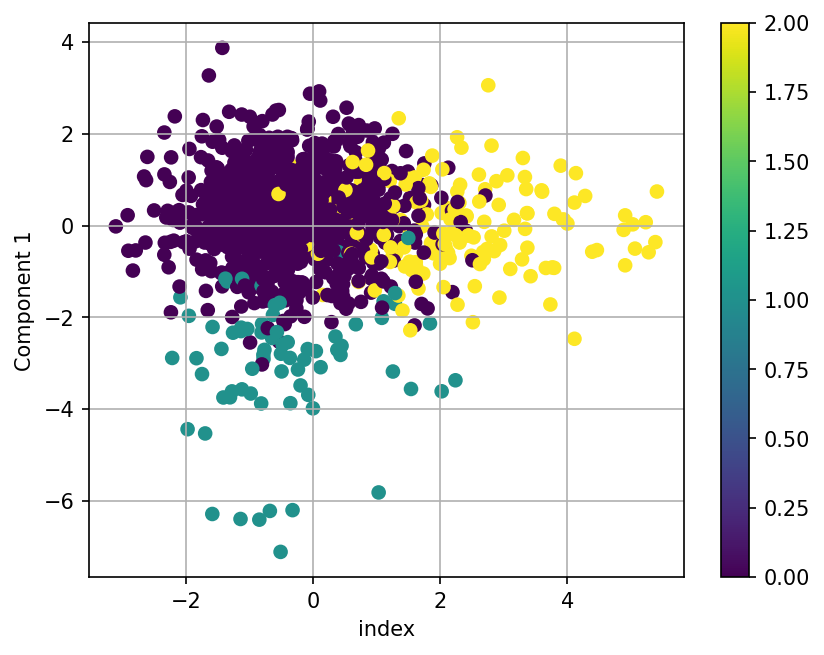

In [24]:
from sklearn.manifold import TSNE
# Load the data
# Create a t-SNE model
tsne = TSNE(n_components=2, perplexity=15,verbose=True,n_iter=2000)
# Fit the model to the data
# tsne_X = tsne.fit_transform(conv)
# Plot the data
plt.figure(dpi=150)
# plt.scatter(np.arange((predictions).shape[0]),predictions, c=y_train[::inc])
plt.scatter(predictions[:,0],predictions[:,1], c=y_train[::inc])
plt.colorbar()
plt.grid(which='both')
plt.xlabel('index')
plt.ylabel('Component 1')
plt.show()
np.save('/content/gdrive/MyDrive/radiomics/TSNE_chexpert_race.npy',{'comp':predictions,'c':y_train[::inc]})